In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import BayesianRidge
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
import ast

# Load data

In [2]:
df_merged = pd.read_csv('../data/Merged.csv')
X = df_merged.iloc[:,1:-1].values
X = StandardScaler().fit_transform(X)

target_labels={'Fermented':[],'Cheesy':[],'Milky':[],'Fruity':[]}
for i in range(len(df_merged.index)):
    label = list(df_merged['Label'])[i]
    for k in target_labels.keys():
        if k == label:
            target_labels[k].append(1)
        else:
            target_labels[k].append(0)          

# Model selection

In [3]:
models_to_try = {
    'LR': LogisticRegression(penalty='l1',
        solver='saga',class_weight='balanced',
        random_state=42),
    'SVM': LinearSVC(penalty='l1',class_weight='balanced',dual=False,
        random_state=42),
    'BRR':BayesianRidge(),
    'GPC':GaussianProcessClassifier(random_state=42)}

In [4]:
result_df = pd.DataFrame(
    columns=['model', 'class', 'train_auc', 'test_auc'] )
N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_labels in target_labels.items():
        print(f'{model_name}: {y_name}')
        
        cv_result = cross_validate(model, X, y= y_labels,
            cv=N_CV, scoring='roc_auc', return_train_score=True,
            verbose=1,n_jobs=4 )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'class': [y_name] * N_CV,
                'train_auc': cv_result['train_score'],
                'test_auc': cv_result['test_score']
            }
        )
        result_df = result_df.append(sub_result_df)

LR
LR: Fermented


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: Cheesy
LR: Milky
LR: Fruity
SVM
SVM: Fermented
SVM: Cheesy
SVM: Milky
SVM: Fruity
BRR
BRR: Fermented
BRR: Cheesy
BRR: Milky
BRR: Fruity
GPC
GPC: Fermented
GPC: Cheesy
GPC: Milky
GPC: Fruity


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concu

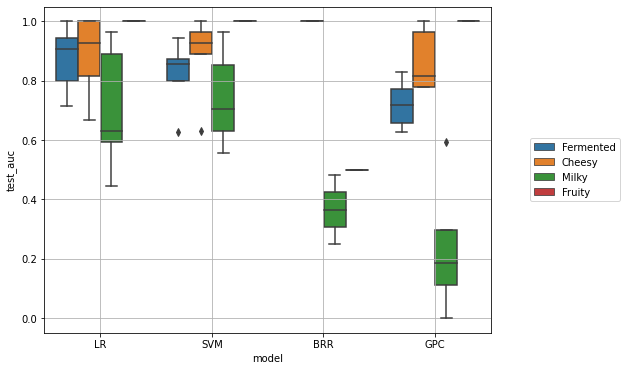

In [5]:
_, ax = plt.subplots(figsize= (8,6))
sns.boxplot(x='model', y='test_auc', data=result_df, hue='class', dodge=True, ax=ax)
ax.grid()
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))

# Hyperparam optimization for Logit Regression

In [6]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(
            solver= 'saga',
            penalty = 'elasticnet',
            class_weight='balanced',
            max_iter = 500,
            verbose=1
        ),
        'param_dists': {
            'C': np.logspace(-1,2,15),
            'l1_ratio':np.linspace(0,1,num=21)
        }
    }
}

In [7]:
hyperopt_LR = {}

for y_name, y_labels in target_labels.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=50,scoring='roc_auc',n_jobs=4,
        cv=5,verbose=1,
        return_train_score=True )

    random_search_hyperopt.fit(  X ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False )
    hyperopt_LR[y_name] = hyperopt_results_df

dfs_with_class = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['class'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_class.append(hyperopt_df)
    
hyperopt_LR_df = pd.concat( dfs_with_class, axis=0, ignore_index=True)

Fermented
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Epoch 1, change: 1.00000000
Epoch 2, change: 0.47614125
Epoch 3, change: 0.21108668
Epoch 4, change: 0.19643661
Epoch 5, change: 0.11931403
Epoch 6, change: 0.10254356
Epoch 7, change: 0.07652689
Epoch 8, change: 0.06451133
Epoch 9, change: 0.06377220
Epoch 10, change: 0.05336749
Epoch 11, change: 0.04685748
Epoch 12, change: 0.04219597
Epoch 13, change: 0.04018428
Epoch 14, change: 0.03708028
Epoch 15, change: 0.03430957
Epoch 16, change: 0.03176555
Epoch 17, change: 0.02979868
Epoch 18, change: 0.02846554
Epoch 19, change: 0.02823420
Epoch 20, change: 0.02561747
Epoch 21, change: 0.02511249
Epoch 22, change: 0.02414597
Epoch 23, change: 0.02183348
Epoch 24, change: 0.02162962
Epoch 25, change: 0.02067216
Epoch 26, change: 0.01997524
Epoch 27, change: 0.01880385
Epoch 28, change: 0.01815269
Epoch 29, change: 0.01786759
Epoch 30, change: 0.01740670
Epoch 31, change: 0.01689085
Epoch 32, change: 0.01635527
Epoch 33,

/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bras5181/miniconda3/lib/python3.8/site-packages/s

hange: 0.00365296
Epoch 116, change: 0.00358559
Epoch 117, change: 0.00360174
Epoch 118, change: 0.00346467
Epoch 119, change: 0.00351402
Epoch 120, change: 0.00342224
Epoch 121, change: 0.00337631
Epoch 122, change: 0.00342268
Epoch 123, change: 0.00335160
Epoch 124, change: 0.00328202
Epoch 125, change: 0.00328628
Epoch 126, change: 0.00326356
Epoch 127, change: 0.00318770
Epoch 128, change: 0.00317409
Epoch 129, change: 0.00314409
Epoch 130, change: 0.00313441
Epoch 131, change: 0.00307222
Epoch 132, change: 0.00303864
Epoch 133, change: 0.00302045
Epoch 134, change: 0.00297341
Epoch 135, change: 0.00297485
Epoch 136, change: 0.00291774
Epoch 137, change: 0.00291542
Epoch 138, change: 0.00287899
Epoch 139, change: 0.00283992
Epoch 140, change: 0.00283701
Epoch 141, change: 0.00276709
Epoch 142, change: 0.00279850
Epoch 143, change: 0.00272894
Epoch 144, change: 0.00272613
Epoch 145, change: 0.00271465
Epoch 146, change: 0.00266404
Epoch 147, change: 0.00262340
Epoch 148, change: 0.0

/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 

 0.01282497
Epoch 40, change: 0.01227208
Epoch 41, change: 0.01206305
Epoch 42, change: 0.01197548
Epoch 43, change: 0.01162245
Epoch 44, change: 0.01121534
Epoch 45, change: 0.01117961
Epoch 46, change: 0.01067468
Epoch 47, change: 0.01069434
Epoch 48, change: 0.01009012
Epoch 49, change: 0.01020906
Epoch 50, change: 0.00982988
Epoch 51, change: 0.00968498
Epoch 52, change: 0.00934077
Epoch 53, change: 0.00917140
Epoch 54, change: 0.00892119
Epoch 55, change: 0.00872727
Epoch 56, change: 0.00872559
Epoch 57, change: 0.00834923
Epoch 58, change: 0.00828684
Epoch 59, change: 0.00818589
Epoch 60, change: 0.00794210
Epoch 61, change: 0.00782475
Epoch 62, change: 0.00778496
Epoch 63, change: 0.00760521
Epoch 64, change: 0.00745764
Epoch 65, change: 0.00731743
Epoch 66, change: 0.00719328
Epoch 67, change: 0.00719777
Epoch 68, change: 0.00697663
Epoch 69, change: 0.00654815
Epoch 70, change: 0.00665709
Epoch 71, change: 0.00645416
Epoch 72, change: 0.00641405
Epoch 73, change: 0.00626232
Ep

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
hyperopt_LR_df.to_csv('../data/hyperopt_LR.csv')

Text(0.5, 1.0, 'Logit Regression')

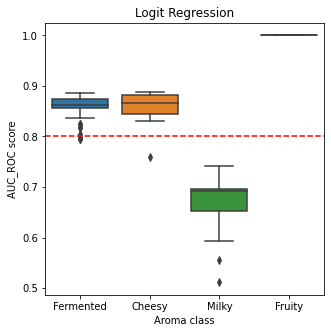

In [9]:
hyperopt_LR_df = pd.read_csv('../data/hyperopt_LR.csv')
plt.figure( figsize=(5,5))
sns.boxplot(x='class', y='mean_test_score', data=hyperopt_LR_df)
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('AUC_ROC score')
plt.xlabel('Aroma class')
plt.title('Logit Regression')

# Hyperparam optimization for Linear SVC

In [10]:
hyperopt_models = {
    'SVM': {
        'model': LinearSVC(class_weight='balanced',dual=False,random_state=42),
        'param_dists': {
            'penalty':['l1', 'l2'], 'C': np.logspace(-1,2,15),
            'fit_intercept':[True, False] }
    }
}

In [11]:
hyperopt_SVM = {}

for y_name, y_labels in target_labels.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['SVM']['model'],
        hyperopt_models['SVM']['param_dists'],
        n_iter=50,scoring='roc_auc',n_jobs=4,
        cv=5,verbose=1,
        return_train_score=True )

    random_search_hyperopt.fit(  X ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score', ascending=False )
    hyperopt_SVM[y_name] = hyperopt_results_df

dfs_with_class = []
for y_name, hyperopt_df in hyperopt_SVM.items():
    hyperopt_df['class'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_class.append(hyperopt_df)
    
hyperopt_SVM_df = pd.concat( dfs_with_class, axis=0, ignore_index=True)

Fermented
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Cheesy
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Milky
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 

Fruity
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [12]:
hyperopt_SVM_df.to_csv('../data/hyperopt_SVM.csv')

Text(0.5, 1.0, 'Linear SVC')

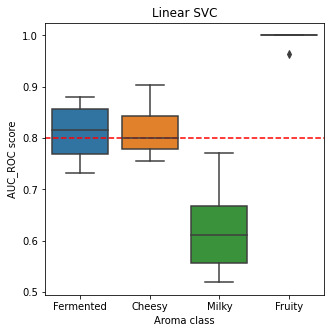

In [13]:
plt.figure( figsize=(5,5))
sns.boxplot(x='class', y='mean_test_score', data=hyperopt_SVM_df)
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('AUC_ROC score')
plt.xlabel('Aroma class')
plt.title('Linear SVC')

# Assess feature importances

In [14]:
import shap
from sklearn.model_selection import train_test_split

In [15]:
hyperopt_LR_df = pd.read_csv('../data/hyperopt_LR.csv')
hyperopt_SVM_df = pd.read_csv('../data/hyperopt_SVM.csv')
cols = [ x  for x in list(df_merged.columns) if (x!= 'Label' )and( x!= 'Sample') ]
X_fi = pd.DataFrame( X, columns= cols, index=df_merged.index)

shap_vals= {}

for aroma in target_labels.keys():
    sub_table = hyperopt_LR_df[ hyperopt_LR_df['class']==aroma]
    sub_table = sub_table.sort_values(by='mean_test_score', ascending=False)
    params = ast.literal_eval( list(sub_table['params'])[0])
    clf = LogisticRegression(solver= 'saga', penalty = 'elasticnet', class_weight='balanced',
            max_iter = 500, verbose=1)
    clf.set_params( l1_ratio = params['l1_ratio'])
    clf.set_params( C = params['C'])
    y = pd.Series( target_labels[aroma] )
    X_train, X_test, y_train, y_test = train_test_split( X_fi, y, test_size=0.3, random_state=42)
    clf.fit(X_train, y_train)
    explainer = shap.Explainer(clf, X_train )
    shap_vals[aroma] = explainer(X_test)

0022546
Epoch 275, change: 0.00022261
Epoch 276, change: 0.00022182
Epoch 277, change: 0.00021687
Epoch 278, change: 0.00021489
Epoch 279, change: 0.00021241
Epoch 280, change: 0.00021500
Epoch 281, change: 0.00020954
Epoch 282, change: 0.00020904
Epoch 283, change: 0.00020626
Epoch 284, change: 0.00020534
Epoch 285, change: 0.00020422
Epoch 286, change: 0.00020205
Epoch 287, change: 0.00019634
Epoch 288, change: 0.00019501
Epoch 289, change: 0.00019312
Epoch 290, change: 0.00019481
Epoch 291, change: 0.00019202
Epoch 292, change: 0.00019104
Epoch 293, change: 0.00018734
Epoch 294, change: 0.00018611
Epoch 295, change: 0.00018264
Epoch 296, change: 0.00018283
Epoch 297, change: 0.00018093
Epoch 298, change: 0.00017752
Epoch 299, change: 0.00017829
Epoch 300, change: 0.00017621
Epoch 301, change: 0.00017602
Epoch 302, change: 0.00017057
Epoch 303, change: 0.00017178
Epoch 304, change: 0.00016900
Epoch 305, change: 0.00016815
Epoch 306, change: 0.00016536
Epoch 307, change: 0.00016458
Ep

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [16]:
target_labels.keys()

dict_keys(['Fermented', 'Cheesy', 'Milky', 'Fruity'])

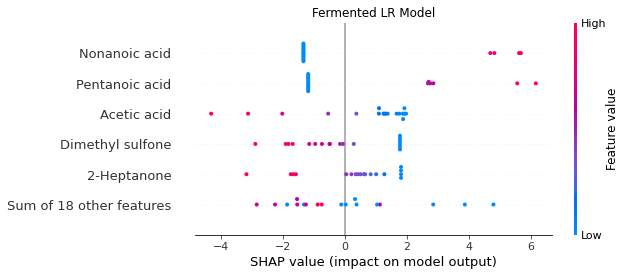

In [17]:
aroma = 'Fermented'
plt.title(aroma+" LR Model")
shap.plots.beeswarm( shap_vals[aroma],max_display=6,show = False)

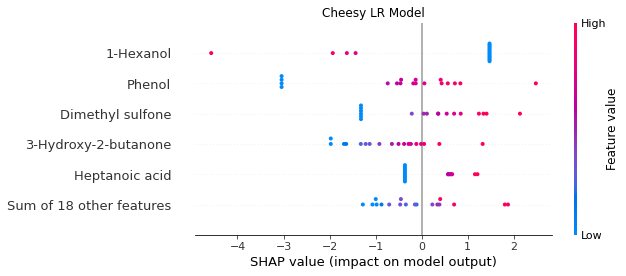

In [18]:
aroma = 'Cheesy'
plt.title(aroma+" LR Model")
shap.plots.beeswarm( shap_vals[aroma],max_display=6,show = False)

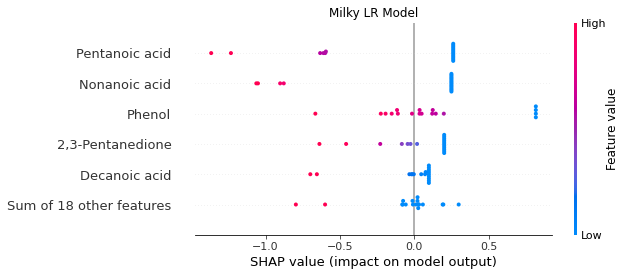

In [19]:
aroma = 'Milky'
plt.title(aroma+" LR Model")
shap.plots.beeswarm( shap_vals[aroma],max_display=6,show = False)

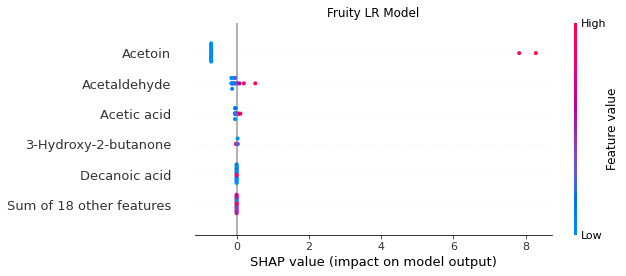

In [20]:
aroma = 'Fruity'
plt.title(aroma+" LR Model")
shap.plots.beeswarm( shap_vals[aroma],max_display=6,show = False)